In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pathlib import Path 
current_path = Path().resolve()

import warnings
warnings.filterwarnings('ignore')

RAW_PATH = current_path.parent / 'data' / 'raw'
OUTPUT_PATH = current_path.parent / 'data' / 'output'
IMGS_PATH = current_path.parent / 'imgs'



%matplotlib inline

In [4]:
plt.style.use('seaborn-paper')

## Median x Mean Comparisson

### Get data

In [5]:
pollution_h3 = pd.concat([pd.read_csv(RAW_PATH / f'raw_pollution_city{i}_h3.csv', index_col=0) for i in [1,2]])

In [6]:
len(pollution_h3)

16465

In [7]:
pollution_h3.head()

,Lon,Lat,NO_Med,NO2_Med,BC_Med,NO_Mean,NO2_Mean,BC_Mean,Speed_Med,Unique_Days,...,Index_Hwy,Index_Domain,NO_SE,NO2_SE,BC_SE,h3id_7,h3id_8,h3id_9,h3id_10,h3id_11
0,-122.305836,37.808121,47.011244,43.184173,2.332410,72.232684,46.539966,3.375462,13.033449,82,...,0,1,2.724004,2.080245,0.147212,872830811ffffff,8828308119fffff,89283081187ffff,8a2830802497fff,8b2830802492fff
1,-122.305702,37.808196,61.504760,45.305978,2.702900,82.330182,48.391790,4.476297,15.451338,60,...,0,1,6.447487,3.198008,0.423799,872830811ffffff,8828308119fffff,89283081187ffff,8a2830802497fff,8b2830802492fff
2,-122.305675,37.807926,65.461539,55.908574,2.593800,95.612270,59.104009,2.649551,10.947377,20,...,0,1,24.511033,10.833200,0.370535,872830811ffffff,8828308119fffff,89283081187ffff,8a2830802497fff,8b2830802492fff
3,-122.305652,37.807967,50.142858,41.317134,1.633319,68.687605,42.583438,3.036578,4.426794,58,...,0,1,2.702267,1.307927,0.098800,872830811ffffff,8828308119fffff,89283081187ffff,8a2830802497fff,8b2830802492fff
4,-122.305496,37.808105,50.474726,39.777000,2.313093,79.554567,44.614032,3.993717,10.438077,81,...,0,1,4.020630,2.186250,0.250747,872830811ffffff,8828308119fffff,89283081187ffff,8a2830811867fff,8b2830811865fff


### Prepare data

list of dict with

keys = [pollutant, statistic, df]

df: 

    columns = [5%, 25%, median, 75%, 95%, mean]

    ordered by mean

In [8]:
translate_statistic = {'Med': 'Median', 'Mean': 'Mean'}
translate_pollutant = {'BC': 'BC', 'NO': 'NO', 'NO2': r'NO$_2$'}
concentration_labels = {
    'BC': r'$\mu$g m$^{-3}$',
    'NO': r'ppb',
    r'NO$_2$': r'ppb'
}

In [9]:
pollution_h3['NO_Med'].kurt()

12.12473156148204

In [10]:
def prepare_data(df, column):    
    
    return {'pollutant': translate_pollutant[column.split('_')[0]],
            'statistic': translate_statistic[column.split('_')[1]],
            'df': df.groupby('h3id_9')[column].agg({
                                  'median': 'median',
                                  'mean': 'mean',
                                  '25%': lambda x: x.quantile(0.25),
                                  '75%': lambda x: x.quantile(0.75),
                                  '5%': lambda x: x.quantile(0.05),
                                  '95%': lambda x: x.quantile(0.95),
                                  'skew': lambda x: x.skew(),
                                  'kurt': lambda x: x.kurt() - 3,
                                  'mean_median_diff': lambda x: x.median() - x.mean()
                                 }).sort_values(by='median')
    }

In [11]:
columns = ['NO_Med', 'NO2_Med', 'BC_Med', 'NO_Mean', 'NO2_Mean', 'BC_Mean']

In [12]:
plot_data = []
for col in columns:
    plot_data.append(prepare_data(pollution_h3, col))

In [13]:
plot_data = sorted(plot_data, key=lambda i: ( i['pollutant'], i['statistic']))

plot_data = [
        [p for i, p in enumerate(plot_data) if j <= i < j+2]
        for j in range(0, len(plot_data), 2)
     ]

### Make Plot

3 x 2

Line Plot

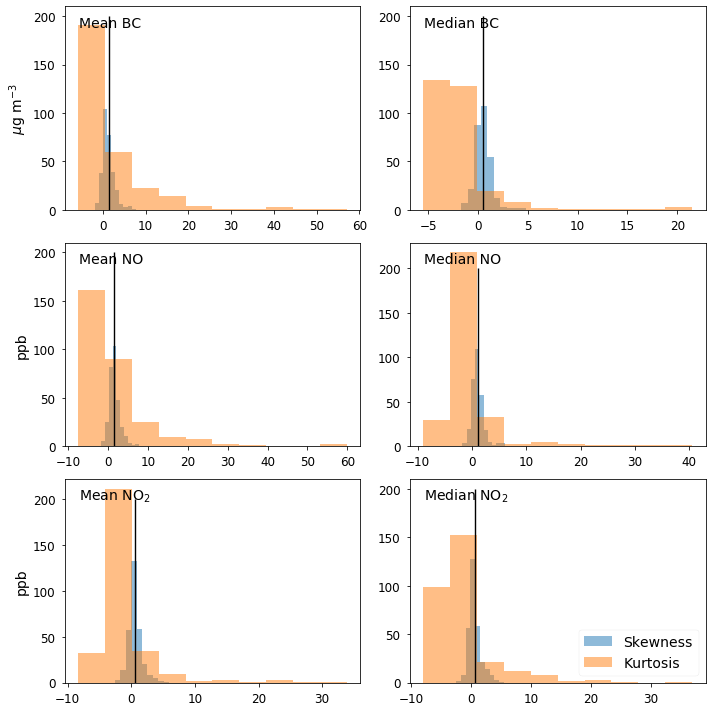

In [14]:
nrows = 3
ncols = 2
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 10))

for r in range(nrows):
    for c in range(ncols):
        
        datum = plot_data[r][c]
        axis = ax[r][c]
        
        axis.hist(datum['df']['skew'],  label='Skewness', alpha=0.5)
        axis.hist(datum['df']['kurt'],  label='Kurtosis', alpha=0.5)
        axis.vlines(datum['df']['skew'].mean(), 0, 200)
#         axis.plot(datum['df'].index, datum['df']['median'], c='b', label='Median' )
        axis.text(0.05, 0.9, ' '.join([datum['statistic'], datum['pollutant']]),
                  transform=axis.transAxes, fontsize=fontsize)
        if c == 0:
            axis.set_ylabel(concentration_labels[datum['pollutant']], fontsize=fontsize)

        if (r == 2) & (c == 1):
                axis.legend(loc='lower right', fontsize=fontsize)
        
#         axis.xaxis.set_visible(False)
        axis.tick_params(axis='both', labelsize=12)
        
fig.tight_layout()
fig.savefig(IMGS_PATH / 'pollution' / 'mean_vs_median.png')

In [15]:
moments = pd.DataFrame()

for r in range(nrows):
    for c in range(ncols):
        
        datum = plot_data[r][c]

        a = datum['df'].reset_index()\
            .melt(id_vars='h3id_9', value_vars=[ 'skew', 'kurt', 'mean_median_diff'])
        a = a.groupby('variable').mean()
        a.columns = [' '.join([datum['statistic'], datum['pollutant']])]
        moments = pd.concat([moments, a], 1)

In [16]:
moments.round(2).T

variable,kurt,mean_median_diff,skew
Mean BC,1.75,-0.08,1.32
Median BC,-1.74,-0.03,0.53
Mean NO,1.51,-4.05,1.56
Median NO,-0.48,-1.51,1.06
Mean NO$_2$,-1.24,-0.46,0.61
Median NO$_2$,-0.98,-0.41,0.65


## Histograms of pollution by hexagon

### Plot Data

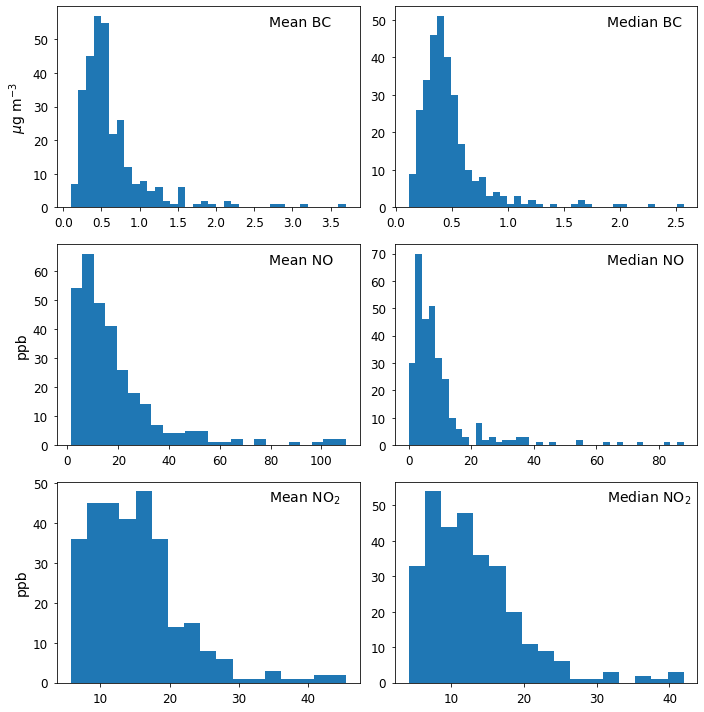

In [17]:
nrows = 3
ncols = 2
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 10))

for r in range(nrows):
    for c in range(ncols):
        
        datum = plot_data[r][c]
        axis = ax[r][c]
        
        axis.hist(datum['df']['median'], bins='fd')
        
        axis.text(0.70, 0.9, ' '.join([datum['statistic'], datum['pollutant']]),
                  transform=axis.transAxes, fontsize=fontsize)
        if c == 0:
            axis.set_ylabel(concentration_labels[datum['pollutant']], fontsize=fontsize)

        axis.tick_params(axis='both', labelsize=12)
        
fig.tight_layout()
fig.savefig(IMGS_PATH / 'pollution' / 'pollution_histograms.png')

## Correlation between pollutants

### Plot Data

1 x 3

In [18]:
from scipy.stats import linregress, powerlaw

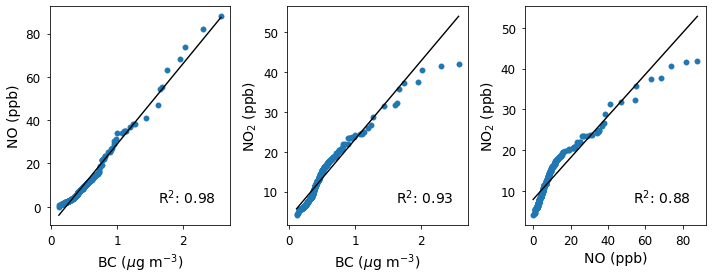

In [19]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))

def plot_scatter(datum_x, datum_y, axis):
    
    axis.scatter(datum_x['df']['median'], 
                 datum_y['df']['median'])
    axis.set_xlabel('{} ({})'.format(datum_x['pollutant'], 
                                     concentration_labels[datum_x['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('{} ({})'.format(datum_y['pollutant'], 
                                     concentration_labels[datum_y['pollutant']]), 
                    fontsize=fontsize)

    axis.tick_params(axis='both', labelsize=12)
    
    reg = linregress(datum_x['df']['median'], datum_y['df']['median'])
    
    axis.plot(datum_x['df']['median'], 
              datum_x['df']['median'] * reg.slope + reg.intercept, 
              c='black')
    
    r_squared = round(np.power(reg.rvalue, 2),2)

    axis.text(0.60, 0.1, f'R$^2$: {r_squared}',
                  transform=axis.transAxes, fontsize=fontsize)
    
    
    
plot_scatter(plot_data[0][1], plot_data[1][1], ax[0])
plot_scatter(plot_data[0][1], plot_data[2][1], ax[1])
plot_scatter(plot_data[1][1], plot_data[2][1], ax[2])

fig.tight_layout()
fig.savefig(IMGS_PATH / 'pollution' / 'pollution_correlation.png')

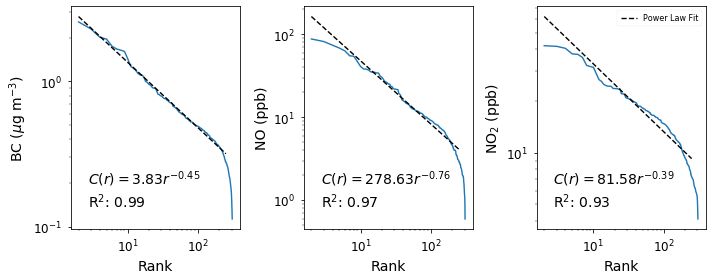

In [20]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))

def plot_scatter(datum,  axis, i):
    
    df = datum['df'].sort_values(by='median', ascending=False)\
        .reset_index()['median']
    
    df = df[df > 0]
    
    df.index = df.index + 2
    
    axis.loglog(df.index, df)

    axis.set_xlabel('Rank', 
                    fontsize=fontsize)
    axis.set_ylabel('{} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)


    axis.tick_params(axis='both', labelsize=12)
    
    df_pl = df[df.index < 250] 
    
    reg = linregress(pd.Series(df_pl.index).apply(np.log10), 
                     df_pl.apply(np.log10))
    
    
    axis.loglog(df_pl.index, 
                (pd.Series(df_pl.index).apply(np.log10) * (reg.slope) + reg.intercept)\
                .apply(lambda x: 10 ** x), '--',
              c='black', label='Power Law Fit')
    
    axis.text(0.10, 0.1, 
              '$C (r) ={%s}r^{%s}$\nR$^2$: %s' % ( round(10 ** reg.intercept,2),
                                              round(reg.slope,2),
                                             round(reg.rvalue ** 2, 2)),
                  transform=axis.transAxes, fontsize=fontsize)
    if i == 2:
        axis.legend(loc='upper right')
    
    
plot_scatter(plot_data[0][1], ax[0], 0)
plot_scatter(plot_data[1][1], ax[1], 1)
plot_scatter(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'pollution' / 'pollution_power_law.png')

In [21]:

df = plot_data[1][1]['df'].sort_values(by='median', ascending=False)\
        .reset_index()['median']

df = df[df > 0]

df.index = df.index + 2 

df_pl = df[df.index < 10] 

linregress(pd.Series(df_pl.index).apply(np.log10), 
                 df_pl.apply(np.log10))

LinregressResult(slope=-0.40741711805357556, intercept=2.09684100649149, rvalue=-0.9698685807491347, pvalue=6.685474766781941e-05, stderr=0.041781033406364985)

In [22]:
df

2      87.956522
3      81.900320
4      73.919997
5      68.285397
6      63.073022
7      55.093752
8      54.437499
9      46.999998
10     40.931817
11     38.222222
12     38.057588
13     37.062500
14     35.189190
15     34.999999
16     34.777778
17     34.150253
18     34.112905
19     31.332192
20     30.471284
21     28.808334
22     27.102906
23     26.556819
24     26.039474
25     25.079232
26     25.066222
27     23.399999
28     23.396688
29     22.307692
30     21.870371
31     21.866456
         ...    
276     2.168675
277     2.118669
278     2.015206
279     2.014925
280     2.000000
281     2.000000
282     2.000000
283     1.994506
284     1.974077
285     1.953488
286     1.935986
287     1.928200
288     1.909091
289     1.909091
290     1.818182
291     1.714286
292     1.615385
293     1.614035
294     1.600000
295     1.500000
296     1.353022
297     1.283333
298     1.212121
299     1.197431
300     1.148214
301     1.129630
302     1.095238
303     0.9500

### Highway Relation Pollution

In [23]:
query = """
WITH d AS (
  SELECT *
  FROM (
  SELECT *, CAST(hour as INTEGER) as hour_int
  FROM "pollution"."waze_jams_hexagons")
  WHERE hour_int between 6 and 18)

SELECT t1.*, t2.*
FROM (
SELECT
  h3id_9,
  MAX(counta) as max_counta,
  AVG(max_length) / MAX(counta) as avg_congested_prop,
  MAX(max_length) as max_length,
  MAX(mean_speed) as max_avg_speed,
  MIN(mean_speed) as min_avg_speed,
  AVG(mean_speed) as avg_speed,
  MAX(median_level) as max_median_level,
  MIN(median_level) as min_median_level,
  approx_percentile(median_level, 0.5) as median_level
  FROM (
SELECT 
  h3id_9,
  pub_utc_date,
  COUNT(uuid) as counta,
  MAX(length) as max_length,
  AVG(speed) as mean_speed,
  approx_percentile(level, 0.5) as median_level
FROM d
GROUP BY h3id_9, pub_utc_date)
GROUP BY h3id_9
) t1
JOIN (
SELECT 
h3id_9,
-- MAX(no2_med) as no2_med,
-- MAX(no_med) as no_med,
-- MAX(bc_med) as bc_med,
MAX(CASE WHEN roadtype = 3 THEN 1 ELSE 0 END) as bool_highway, -- if there is highway in the hexagon,
MAX(CASE WHEN roadtype = 6 THEN 1 ELSE 0 END) as bool_primary, -- if there is highway in the hexagon,
MAX(CASE WHEN roadtype = 4 THEN 1 ELSE 0 END) as bool_ramps, -- if there is highway in the hexagon,
MAX(CASE WHEN roadtype = 7 THEN 1 ELSE 0 END) as bool_secondary, -- if there is highway in the hexagon,
SUM(CASE WHEN roadtype = 3 THEN 1 ELSE 0 END) as count_highway,
SUM(CASE WHEN roadtype = 1 THEN 1 ELSE 0 END) as count_streets,
SUM(CASE WHEN roadtype = 6 THEN 1 ELSE 0 END) as count_primary,
SUM(CASE WHEN roadtype = 7 THEN 1 ELSE 0 END) as count_secondary,
SUM(CASE WHEN roadtype = 2 THEN 1 ELSE 0 END) as count_primary_street, 
SUM(CASE WHEN roadtype = 4 THEN 1 ELSE 0 END) as count_primary_ramps, 
approx_percentile(roadtype, 0.5) as usual_road_type
FROM d
GROUP BY h3id_9) t2
ON t1.h3id_9 = t2.h3id_9
"""

### Read data

In [55]:
waze_features = pd.read_csv(RAW_PATH / 'waze_features_05_23.csv')

In [56]:
waze_features.head()

,h3id_9,max_counta,avg_congested_prop,max_length,max_avg_speed,min_avg_speed,avg_speed,max_median_level,min_median_level,median_level,...,bool_primary,bool_ramps,bool_secondary,count_highway,count_streets,count_primary,count_secondary,count_primary_street,count_primary_ramps,usual_road_type
0,8928308110bffff,2,433.310580,994,7.744444,0.427778,2.883030,4,2,4,...,1,1,0,0,0,110,0,11,189,4
1,89283081143ffff,1,183.940000,603,3.966667,0.000000,0.125667,5,2,5,...,0,0,1,0,1,0,99,0,0,7
2,892830811cfffff,3,63.503401,989,4.205556,0.000000,0.183248,5,2,5,...,0,0,1,0,0,0,278,4,0,7
3,892830810a3ffff,1,302.541667,679,3.350000,1.111111,1.940162,4,3,3,...,0,0,1,0,1,0,11,12,0,2
4,89283098387ffff,2,288.325581,1648,6.227778,0.913889,2.952853,4,2,4,...,0,0,1,0,0,0,265,0,0,7


In [57]:
len(waze_features)

283

In [27]:
interesting_columns = [c for c in waze_features.columns if 'count_' in c] + ['h3id_9']

In [28]:
interesting_columns

['count_highway',
 'count_streets',
 'count_primary',
 'count_secondary',
 'count_primary_street',
 'count_primary_ramps',
 'h3id_9']

In [29]:
waze_features = waze_features[interesting_columns]

In [30]:
waze_features.set_index('h3id_9', inplace=True)

In [31]:
waze_features['w.highway'] = waze_features['count_highway'].apply(lambda x: x > 0)

In [32]:
waze_features['w.primary'] = waze_features[['count_highway', 'count_primary']].apply(lambda x: (x['count_highway'] == 0) 
                                                                                             & (x['count_primary'] > 0), 1)

In [33]:
waze_features['w.rest'] = waze_features[['count_highway', 'count_primary']].apply(lambda x: (x['count_highway'] == 0), 1)

In [34]:
waze_features.head()

,count_highway,count_streets,count_primary,count_secondary,count_primary_street,count_primary_ramps,w.highway,w.primary,w.rest
h3id_9,,,,,,,,,
8928308110bffff,0,0,110,0,11,189,False,True,True
89283081143ffff,0,1,0,99,0,0,False,False,True
892830811cfffff,0,0,0,278,4,0,False,False,True
892830810a3ffff,0,1,0,11,12,0,False,False,True
89283098387ffff,0,0,0,265,0,0,False,False,True


### Prepare Data



In [35]:
cat_highway = waze_features.reset_index().melt(id_vars='h3id_9', value_vars='w.highway', value_name='category')
translate = {True: 'With\nHighway', False: 'Without\nHighway'}
cat_highway['category'] = cat_highway['category'].apply(lambda x: translate[x])

In [36]:
cat_highway.head(1)

,h3id_9,variable,category
0,8928308110bffff,w.highway,Without\nHighway


### Plot data

In [37]:
import seaborn as sns

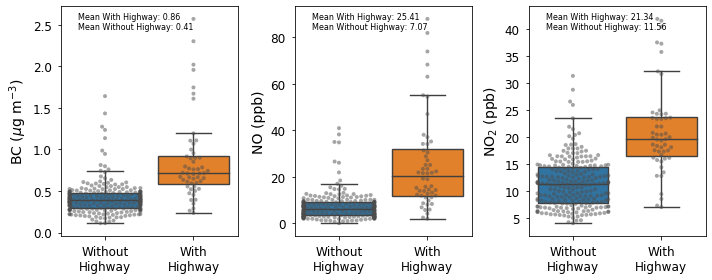

In [38]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    df = datum['df'].merge(cat_highway, on='h3id_9')
    sns.boxplot(x='category', y='median', data=df, ax=axis, fliersize=0)
    sns.swarmplot(x='category', y='median', data=df, ax=axis,
                  size=4, color=".3", linewidth=0, alpha=0.5)
    
    axis.set_xlabel('')
    axis.set_ylabel('{} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    
    axis.tick_params(axis='both', labelsize=12)
    
    mean_highway = round(df[df['category'].str.contains('With\n')]["median"].mean(), 2)
    mean_whighway = round(df[df['category'].str.contains('Without\n')]["median"].mean(), 2)
    axis.text(0.10, 0.9, f'Mean With Highway: {mean_highway}\nMean Without Highway: {mean_whighway}',
          transform=axis.transAxes, fontsize=8)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'highway_bool.png')

In [39]:
sum(cat_highway['category'] == 'With\nHighway')

52

In [40]:
len(cat_highway)

283

In [41]:
52/283*100

18.374558303886925

### Modeling

Basic model

$Y = \alpha X_{highway} + \beta$

where $X_{highway}$ is a boolean



In [42]:
bool_highway = waze_features['w.highway'].apply(int).to_frame().reset_index()

In [43]:
bool_highway.to_csv(RAW_PATH / 'h3_with_highway.csv')

In [44]:
def calculate_mse(y, y_hat):

    return np.apply_along_axis(lambda x: np.power(x, 2), 0, y.values - y_hat.values).mean()

for i in range(3):
    df = bool_highway.merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    model = linregress(df['w.highway'], df['median'])
    plot_data[i][1]['model_linear_highway_bool'] = {}
    plot_data[i][1]['model_linear_highway_bool']['args'] = model
    
    y_hat = model.slope * df['w.highway'] + model.intercept
    y_hat.name = 'y_hat'
    plot_data[i][1]['model_linear_highway_bool']['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1]['model_linear_highway_bool']['mse'] = mse
    

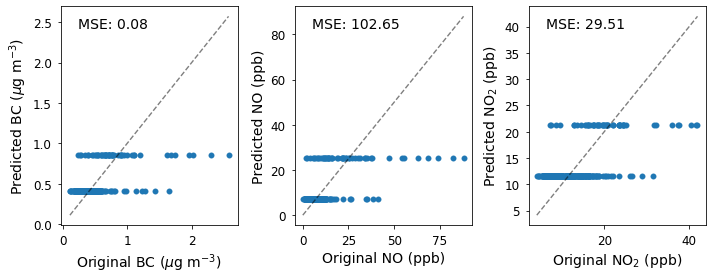

In [45]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_linear_highway_bool']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_linear_highway_bool"]["mse"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_linear_highway_bool.png')

In [46]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse']
    })
pd.DataFrame(results).set_index('Pollutant')

,Simple Highway (MSE)
Pollutant,
BC,0.078318
NO,102.647823
NO$_2$,29.510847


## Waze other road types pollution

### Modeling

$Y = \alpha_1 X_1 + ... + \alpha_n X_n + \beta$

where $X_n$ corresponds to a road type count

In [50]:
import statsmodels.api as sm # import statsmodels 

In [51]:
interesting_columns = ['count_highway',
 'count_streets',
 'count_primary',
 'count_secondary',
 'count_primary_street',
 'count_primary_ramps']

In [52]:
model_name = 'model_multilinear_highway'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[interesting_columns]
    y = df['median']

    # Note the difference in argument order
    model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = predictions
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

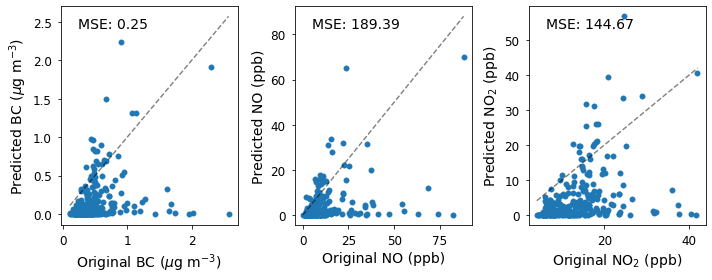

In [53]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_multilinear_highway']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_multilinear_highway"]["mse"], 2)}',
              transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_multilinear_highway.png')

In [54]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse']
    })
pd.DataFrame(results).set_index('Pollutant')

,Road Types (MSE),Simple Highway (MSE)
Pollutant,,
BC,0.249742,0.078318
NO,189.390408,102.647823
NO$_2$,144.666846,29.510847


### Linear Regression with All available Features

In [55]:
waze_features = pd.read_csv(RAW_PATH / 'waze_features_05_23.csv')

### Modeling

In [56]:
columns = ['avg_congested_prop', 'max_length',
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level',  'bool_highway',
       'bool_primary', 'bool_ramps', 'bool_secondary', 'count_highway',
       'count_streets', 'count_primary', 'count_secondary',
       'count_primary_street', 'count_primary_ramps', 'usual_road_type']

In [57]:
model_name = 'model_multilinear'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[columns]
    y = df['median']

    # Note the difference in argument order
    model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = predictions
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

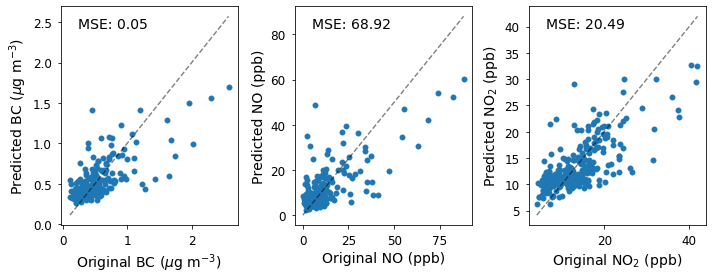

In [58]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_multilinear']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_multilinear"]["mse"], 2)}',
              transform=axis.transAxes, fontsize=fontsize)
    
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_multilinear.png')

In [59]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse'],
        'MultiLinear (MSE)': plot_data[i][1]['model_multilinear']['mse'],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='BC', ascending=False).T

,Road Types (MSE),Simple Highway (MSE),MultiLinear (MSE)
Pollutant,,,
BC,0.249742,0.078318,0.052809
NO,189.390408,102.647823,68.916483
NO$_2$,144.666846,29.510847,20.494198


## Random Forest in all variables

### Modeling

In [60]:
from sklearn.ensemble import RandomForestRegressor


In [61]:
model_name = 'model_random_forest'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[columns]
    y = df['median']

    # Note the difference in argument order
    model = RandomForestRegressor(min_samples_split=2).fit(X, y) ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = pd.Series(predictions, index=df.index)
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

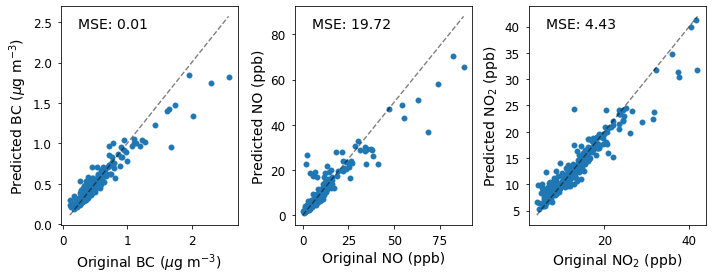

In [62]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_random_forest"]["mse"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest.png')

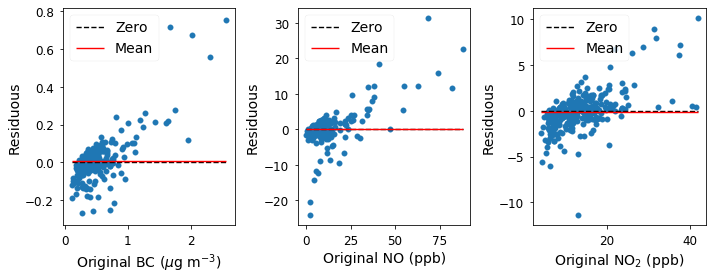

In [63]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(
        x=df['median'], 
        y=df['median'] - df['y_hat'])
    
    axis.hlines(0, df['median'].min(), df['median'].max(), linestyles='--', colors='black', label='Zero')
    
    axis.hlines((df['median'] - df['y_hat']).mean(), df['median'].min(), df['median'].max(), label='Mean', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
    
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest_residuous.png')


In [64]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse'],
        'MultiLinear (MSE)': plot_data[i][1]['model_multilinear']['mse'],
        'Random Forest (MSE)': plot_data[i][1]['model_random_forest']['mse'],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='BC', ascending=False).T

,Road Types (MSE),Simple Highway (MSE),MultiLinear (MSE),Random Forest (MSE)
Pollutant,,,,
BC,0.249742,0.078318,0.052809,0.012387
NO,189.390408,102.647823,68.916483,19.723871
NO$_2$,144.666846,29.510847,20.494198,4.428538


### Lighter Random Forest



In [65]:
model_name = 'model_random_forest_light'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[columns]
    y = df['median']

    # Note the difference in argument order
    model = RandomForestRegressor(min_samples_split=4).fit(X, y) ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = pd.Series(predictions, index=df.index)
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

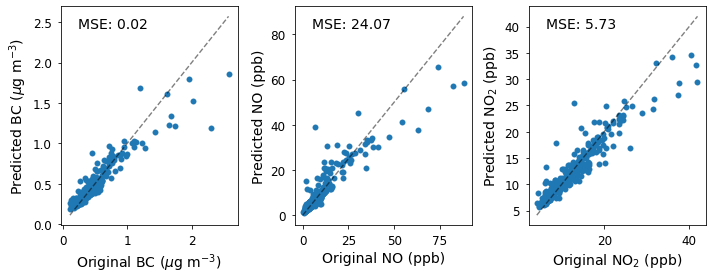

In [66]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest_light']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_random_forest_light"]["mse"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest_light.png')

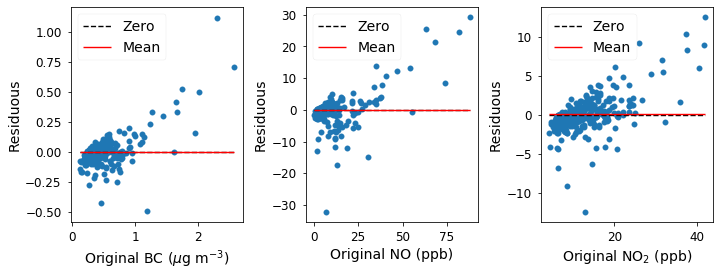

In [67]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest_light']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(
        x=df['median'], 
        y=df['median'] - df['y_hat'])
    
    axis.hlines(0, df['median'].min(), df['median'].max(), linestyles='--', colors='black', label='Zero')
    
    axis.hlines((df['median'] - df['y_hat']).mean(), df['median'].min(), df['median'].max(), label='Mean', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
    
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest_light_residuous.png')


In [68]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse'],
        'MultiLinear (MSE)': plot_data[i][1]['model_multilinear']['mse'],
        'Random Forest (MSE)': plot_data[i][1]['model_random_forest']['mse'],
        'Light Random Forest (MSE)': plot_data[i][1]['model_random_forest_light']['mse'],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='BC', ascending=False).T

,Road Types (MSE),Simple Highway (MSE),MultiLinear (MSE),Light Random Forest (MSE),Random Forest (MSE)
Pollutant,,,,,
BC,0.249742,0.078318,0.052809,0.016268,0.012387
NO,189.390408,102.647823,68.916483,24.065516,19.723871
NO$_2$,144.666846,29.510847,20.494198,5.729643,4.428538


## Feature Importance, Correlation and Elimination

### Importance

The feature importance for a random forest classifier can be downgraded by correlated features and are biased for features with many categories.

In [161]:
feature_importance = {'feature': columns}

for i in range(3):
    model = plot_data[i][1]['model_random_forest']['args']
    
    feature_importance[plot_data[i][1]["pollutant"]] = model.feature_importances_
    
feature_importance = pd.DataFrame(feature_importance).set_index('feature')
feature_importance['Mean'] = feature_importance.mean(1)
feature_importance.sort_values(by='Mean', ascendi 

SyntaxError: unexpected EOF while parsing (<ipython-input-161-5eb2d735e5ae>, line 10)

In [80]:
print(feature_importance.sort_values(by='Mean', ascending=False).round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     BC &     NO &  NO\$\_2\$ &   Mean \\
feature              &        &        &         &        \\
\midrule
max\_length           &  0.323 &  0.270 &   0.312 &  0.301 \\
avg\_congested\_prop   &  0.185 &  0.239 &   0.104 &  0.176 \\
avg\_speed            &  0.141 &  0.213 &   0.120 &  0.158 \\
count\_highway        &  0.064 &  0.077 &   0.118 &  0.086 \\
count\_primary\_ramps  &  0.052 &  0.031 &   0.055 &  0.046 \\
min\_median\_level     &  0.076 &  0.015 &   0.042 &  0.044 \\
bool\_highway         &  0.032 &  0.017 &   0.081 &  0.043 \\
bool\_ramps           &  0.050 &  0.042 &   0.024 &  0.038 \\
count\_primary\_street &  0.021 &  0.031 &   0.037 &  0.030 \\
count\_streets        &  0.025 &  0.015 &   0.043 &  0.028 \\
count\_primary        &  0.011 &  0.033 &   0.035 &  0.026 \\
count\_secondary      &  0.022 &  0.016 &   0.029 &  0.022 \\
\bottomrule
\end{tabular}



### Correlation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f7b198>]],
      dtype=object)

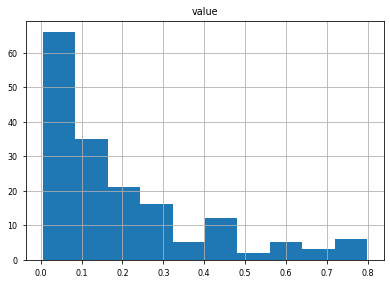

In [70]:
correlation_pairs = X.corr().reset_index().melt(id_vars='index', value_vars=columns)\
                    .query('index != variable').drop_duplicates(subset=['value'])
correlation_pairs['value'] = correlation_pairs['value'].apply(abs)
correlation_pairs = correlation_pairs.sort_values(by='value', ascending=False)
correlation_pairs.hist()

In [71]:
exclude_features = ['min_avg_speed', 
                    'max_avg_speed', 'bool_primary', 'bool_secondary', 'usual_road_type',
                    'max_median_level', 'median_level']

In [72]:
correlation_pairs.head(10)

,index,variable,value
21,max_avg_speed,max_length,0.799308
46,bool_highway,max_avg_speed,0.797514
4,avg_speed,avg_congested_prop,0.790823
1,max_length,avg_congested_prop,0.774724
27,bool_highway,max_length,0.754114
61,avg_speed,min_avg_speed,0.722021
42,avg_speed,max_avg_speed,0.716847
23,avg_speed,max_length,0.668540
62,max_median_level,min_avg_speed,0.646184
3,min_avg_speed,avg_congested_prop,0.618536


### Modeling



In [73]:
new_columns = [c for c in columns if c not in exclude_features]

In [74]:
new_columns

['avg_congested_prop',
 'max_length',
 'avg_speed',
 'min_median_level',
 'bool_highway',
 'bool_ramps',
 'count_highway',
 'count_streets',
 'count_primary',
 'count_secondary',
 'count_primary_street',
 'count_primary_ramps']

In [75]:
model_name = 'model_random_forest_less_features'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[new_columns]
    y = df['median']

    # Note the difference in argument order
    model = RandomForestRegressor(min_samples_split=2).fit(X, y) ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = pd.Series(predictions, index=df.index)
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = calculate_mse(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

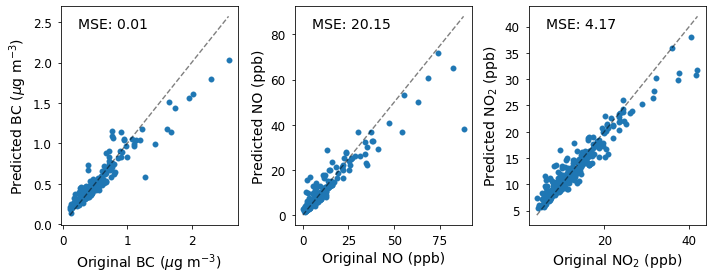

In [76]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest_less_features']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum["model_random_forest_less_features"]["mse"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest_less_features.png')

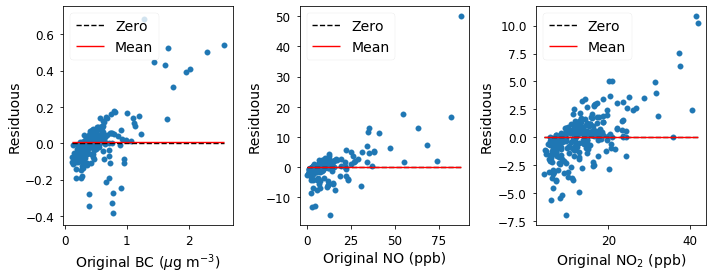

In [77]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum['model_random_forest_less_features']['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(
        x=df['median'], 
        y=df['median'] - df['y_hat'])
    
    axis.hlines(0, df['median'].min(), df['median'].max(), linestyles='--', colors='black', label='Zero')
    
    axis.hlines((df['median'] - df['y_hat']).mean(), df['median'].min(), df['median'].max(), label='Mean', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
    
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / 'model_random_forest_less_features_residuous.png')


In [78]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse'],
        'MultiLinear (MSE)': plot_data[i][1]['model_multilinear']['mse'],
        'Random Forest (MSE)': plot_data[i][1]['model_random_forest']['mse'],
        'Random Forest Ligth (MSE)': plot_data[i][1]['model_random_forest_light']['mse'],
        'Random Forest Less Features (MSE)': plot_data[i][1]['model_random_forest_less_features']['mse'],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='BC', ascending=False)

Pollutant,BC,NO,NO$_2$
Road Types (MSE),0.249742,189.390408,144.666846
Simple Highway (MSE),0.078318,102.647823,29.510847
MultiLinear (MSE),0.052809,68.916483,20.494198
Random Forest Ligth (MSE),0.016268,24.065516,5.729643
Random Forest Less Features (MSE),0.013285,20.151546,4.174560
Random Forest (MSE),0.012387,19.723871,4.428538


### New Feature Importance

In [79]:
feature_importance = {'feature': new_columns}

for i in range(3):
    model = plot_data[i][1]['model_random_forest_less_features']['args']
    
    
    feature_importance[plot_data[i][1]["pollutant"]] = model.feature_importances_
    
feature_importance = pd.DataFrame(feature_importance).set_index('feature')
feature_importance['Mean'] = feature_importance.mean(1)
feature_importance.sort_values(by='Mean', ascending=False).round(3)

,BC,NO,NO$_2$,Mean
feature,,,,
max_length,0.323,0.270,0.312,0.301
avg_congested_prop,0.185,0.239,0.104,0.176
avg_speed,0.141,0.213,0.120,0.158
count_highway,0.064,0.077,0.118,0.086
count_primary_ramps,0.052,0.031,0.055,0.046
min_median_level,0.076,0.015,0.042,0.044
bool_highway,0.032,0.017,0.081,0.043
bool_ramps,0.050,0.042,0.024,0.038
count_primary_street,0.021,0.031,0.037,0.030


In [ ]:
feature_importance.drop(['count_streets', 'bool_ramps']).sort_values(by='Mean', ascending=False).round(3)

In [81]:
print(feature_importance.sort_values(by='Mean', ascending=False).round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     BC &     NO &  NO\$\_2\$ &   Mean \\
feature              &        &        &         &        \\
\midrule
max\_length           &  0.323 &  0.270 &   0.312 &  0.301 \\
avg\_congested\_prop   &  0.185 &  0.239 &   0.104 &  0.176 \\
avg\_speed            &  0.141 &  0.213 &   0.120 &  0.158 \\
count\_highway        &  0.064 &  0.077 &   0.118 &  0.086 \\
count\_primary\_ramps  &  0.052 &  0.031 &   0.055 &  0.046 \\
min\_median\_level     &  0.076 &  0.015 &   0.042 &  0.044 \\
bool\_highway         &  0.032 &  0.017 &   0.081 &  0.043 \\
bool\_ramps           &  0.050 &  0.042 &   0.024 &  0.038 \\
count\_primary\_street &  0.021 &  0.031 &   0.037 &  0.030 \\
count\_streets        &  0.025 &  0.015 &   0.043 &  0.028 \\
count\_primary        &  0.011 &  0.033 &   0.035 &  0.026 \\
count\_secondary      &  0.022 &  0.016 &   0.029 &  0.022 \\
\bottomrule
\end{tabular}



- Descriptive features are less important
- Activity features are more important overall
- Highway and ramps count are important because they indicate regions with heavy traffic
- NO2 has a highwer use of descriptive features because of its odd high pollutant density behaviour

## XGboost Model

In [76]:
import xgboost as xgb

In [80]:
model_name = 'model_xgboost_less_features'

for i in range(3):
    
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')

    X = df[new_columns]
    y = df['median']

    # Note the difference in argument order
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42).fit(X, y) ## sm.OLS(output, input)
    predictions = model.predict(X)

    # Print out the statistics
    
    plot_data[i][1][model_name] = {}
    plot_data[i][1][model_name]['args'] = model
    
    y_hat = pd.Series(predictions, index=df.index)
    y_hat.name = 'y_hat'
    plot_data[i][1][model_name]['y_hat'] = y_hat
    
    mse = mean_squared_error(df['median'] , y_hat)
    plot_data[i][1][model_name]['mse'] = mse

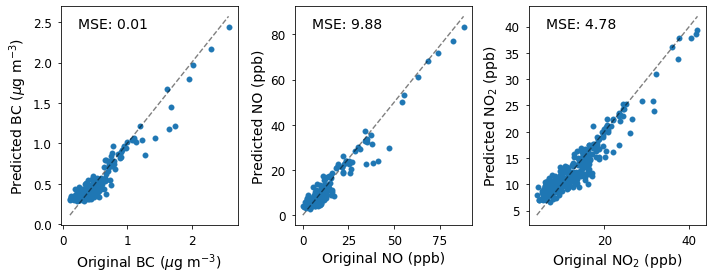

In [81]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum[model_name]['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(df['median'], df['y_hat'])
    
    axis.plot(df['median'], df['median'], '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(datum[model_name]["mse"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')

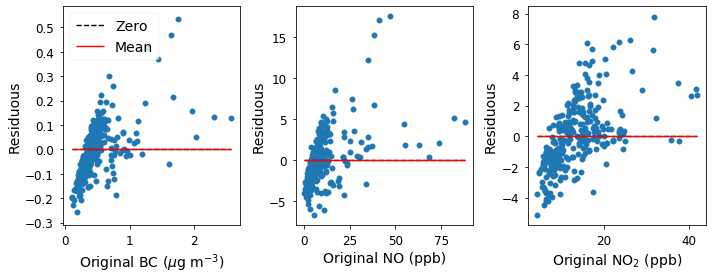

In [82]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    df = datum['df'].merge(datum[model_name]['y_hat'].to_frame().reset_index(), on='h3id_9')
    
    axis.scatter(
        x=df['median'], 
        y=df['median'] - df['y_hat'])
    
    axis.hlines(0, df['median'].min(), df['median'].max(), linestyles='--', colors='black', label='Zero')
    
    axis.hlines((df['median'] - df['y_hat']).mean(), df['median'].min(), df['median'].max(), label='Mean', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
    if  i < 1:
        axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}_residuous.png')


In [83]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Simple Highway (MSE)': plot_data[i][1]['model_linear_highway_bool']['mse'],
        'Road Types (MSE)': plot_data[i][1]['model_multilinear_highway']['mse'],
        'MultiLinear (MSE)': plot_data[i][1]['model_multilinear']['mse'],
        'Random Forest (MSE)': plot_data[i][1]['model_random_forest']['mse'],
        'Random Forest Ligth (MSE)': plot_data[i][1]['model_random_forest_light']['mse'],
        'Random Forest Less Features (MSE)': plot_data[i][1]['model_random_forest_less_features']['mse'],
        'XGBoost Less Features (MSE)': plot_data[i][1]['model_xgboost_less_features']['mse'],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)

Pollutant,BC,NO,NO$_2$
Road Types (MSE),0.249742,189.390408,144.666846
Simple Highway (MSE),0.078318,102.647823,29.510847
MultiLinear (MSE),0.052809,68.916483,20.494198
Random Forest Ligth (MSE),0.015615,25.654352,5.009790
Random Forest (MSE),0.011532,19.055724,4.644271
Random Forest Less Features (MSE),0.010053,16.697018,3.772689
XGBoost Less Features (MSE),0.011318,9.880275,4.779387


## Hyperparameter tuning and preprocessing

In [90]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

In [196]:
def evaluate(model, X_validation, y_validation):
    
    y_hat = model.predict(X_validation)
    
    mse = round(mean_squared_error(y_validation, y_hat), 3)
    
    print('MSE: ', mse)

    return mse

### preprocessing

In [92]:
for i in range(3):
    df = waze_features.reset_index().merge(plot_data[i][1]['df'], on='h3id_9').set_index('h3id_9')[new_columns + ['median']]

    # Reescaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[new_columns] = scaler.fit_transform(df[new_columns].values)
    
    # Spliting
    df_train, df_validation = train_test_split(df, train_size=0.9, random_state=422)

    plot_data[i][1]['model_data'] = {}
    plot_data[i][1]['model_data']['X'] = df[new_columns]
    plot_data[i][1]['model_data']['y'] = df['median']
    plot_data[i][1]['model_data']['X_train'] = df_train[new_columns]
    plot_data[i][1]['model_data']['X_validation'] = df_validation[new_columns]
    plot_data[i][1]['model_data']['y_train'] = df_train['median']
    plot_data[i][1]['model_data']['y_validation'] = df_validation['median']
    
    plot_data[i][1]['model_data']['scaler'] = deepcopy(scaler)

In [166]:
len(waze_features) * 0.1

28.3

In [162]:
len(plot_data[i][1]['model_data']['X_train'])

KeyError: 'model_data'

In [93]:
df.columns

Index(['avg_congested_prop', 'max_length', 'avg_speed', 'min_median_level',
       'bool_highway', 'bool_ramps', 'count_highway', 'count_streets',
       'count_primary', 'count_secondary', 'count_primary_street',
       'count_primary_ramps', 'median'],
      dtype='object')

### Random Forest

#### Random Search and Grid Search

In [94]:
model_name = 'optimized_random_forest'

In [96]:
model_name = 'optimized_random_forest'
for i in range(0,3):
    
    plot_data[i][1][model_name] = {}
    model_dict = plot_data[i][1][model_name]

    model_dict['estimator'] = RandomForestRegressor(random_state=42)

    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 5)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    model_dict['random_grid'] = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    model_dict['RandomSearch'] = RandomizedSearchCV(estimator=model_dict['estimator'],
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               param_distributions=model_dict['random_grid'], n_iter=200, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_dict['RandomSearch'].fit(plot_data[i][1]['model_data']['X_train'],
                                   plot_data[i][1]['model_data']['y_train'])
    
    model_dict['MSE'] = {}

    print('Standard Estimator ')
    model_dict['MSE']['standard'] = evaluate(RandomForestRegressor(random_state=42).fit(
                         plot_data[i][1]['model_data']['X_train'],
                         plot_data[i][1]['model_data']['y_train']),
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )

    print('Tuned Estimator ')
    model_dict['MSE']['RandomSearch'] = evaluate(model_dict['RandomSearch'].best_estimator_,
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )
    
    bp = model_dict['RandomSearch'].best_params_
    
    def multiples(x):
        
        if x is None:
            return [None]
        elif x <= 2:
            return [int(x), x*2, x*4]
        else:
            return [int(x/2), x, x*2] 

    model_dict['param_grid'] = {
        'bootstrap': [bp['bootstrap']],
        'max_depth': multiples(bp['max_depth']),
        'max_features': [bp['max_features']],
        'min_samples_leaf': multiples(bp['min_samples_leaf']),
        'min_samples_split': multiples(bp['min_samples_split']) ,
        'n_estimators': multiples(bp['n_estimators'])
    }

        # Create a based model
    model_dict['GridSearchCV'] = GridSearchCV(estimator=model_dict['estimator'],
                                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                                   param_grid=model_dict['param_grid'],  
                                   cv = 3, verbose=2, n_jobs = -1)
    # Fit the random search model
    model_dict['GridSearchCV'].fit(plot_data[i][1]['model_data']['X_train'],
                               plot_data[i][1]['model_data']['y_train'])
    
    print('Standard Estimator ')
    print(model_dict['MSE']['standard'])

    print('Random Tuned Estimator')
    print(model_dict['MSE']['RandomSearch'])

    print('Grid Search Tuned Estimator ')
    model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation']
            )
    

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 11.7min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Standard Estimator 
MSE:  0.09
Tuned Estimator 
MSE:  0.074
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Standard Estimator 
0.09
Random Tuned Estimator
0.074
Grid Search Tuned Estimator 
MSE:  0.063
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.1min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Standard Estimator 
MSE:  86.253
Tuned Estimator 
MSE:  68.533
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    4.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Standard Estimator 
86.253
Random Tuned Estimator
68.533
Grid Search Tuned Estimator 
MSE:  68.533
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Standard Estimator 
MSE:  27.983
Tuned Estimator 
MSE:  18.593
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  9.5min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Standard Estimator 
27.983
Random Tuned Estimator
18.593
Grid Search Tuned Estimator 
MSE:  18.488


In [812]:
def multiples(x):

    if x is None:
        return [None]
    elif x <= 2:
        return [x, x*2, x*4]
    else:
        return [int(x/2), x, x*2] 

model_dict['param_grid'] = {
    'bootstrap': [bp['bootstrap']],
    'max_depth': multiples(bp['max_depth']),
    'max_features': [bp['max_features']],
    'min_samples_leaf': multiples(bp['min_samples_leaf']),
    'min_samples_split': multiples(bp['min_samples_split']) ,
    'n_estimators': multiples(bp['n_estimators'])
}

    # Create a based model
model_dict['GridSearchCV'] = GridSearchCV(estimator=model_dict['estimator'],
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               param_grid=model_dict['param_grid'],  
                               cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
model_dict['GridSearchCV'].fit(plot_data[i][1]['model_data']['X_train'],
                           plot_data[i][1]['model_data']['y_train'])

print('Standard Estimator ')
print(model_dict['MSE']['standard'])

print('Random Tuned Estimator')
print(model_dict['MSE']['RandomSearch'])

print('Grid Search Tuned Estimator ')
model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
         plot_data[i][1]['model_data']['X_validation'],
         plot_data[i][1]['model_data']['y_validation']
        )

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.0s


Standard Estimator 
86.253
Random Tuned Estimator
68.533
Grid Search Tuned Estimator 
MSE:  68.533


[Parallel(n_jobs=-1)]: Done 240 out of 243 | elapsed:   18.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   18.1s finished


In [749]:
for i in range(3):
    model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation']
            )

MSE:  0.059
MSE:  268.749
MSE:  220.797


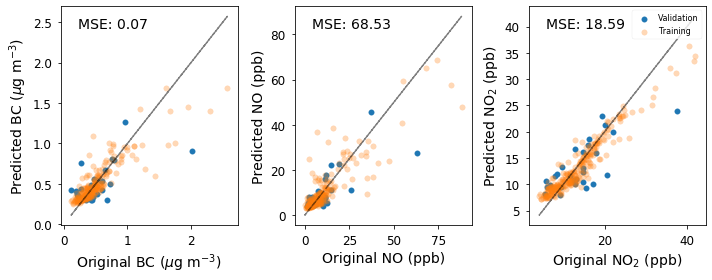

In [97]:
### Plotsnrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    axis.scatter(y, y_hat, label='Validation')
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_train'])
    y = datum['model_data']['y_train']
    axis.scatter(y, y_hat, label='Training', alpha=0.3)
    
    axis.plot(y, y, '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(model["MSE"]["RandomSearch"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
    if i == 2:
        axis.legend(loc='upper right')
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')

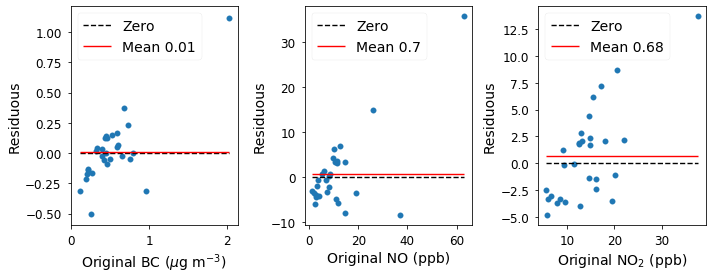

In [98]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    
    axis.scatter(y, y - y_hat)    
    
    axis.hlines(0, y.min(), y.max(), linestyles='--', colors='black', label='Zero')
    
    mean = round((y - y_hat).mean(), 2)
    axis.hlines(mean, y.min(), y.max(), label=f'Mean {mean}', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
#     if  i < 1:
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}_residuous.png')


In [99]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Random Forest': plot_data[i][1]['optimized_random_forest']["MSE"]["RandomSearch"],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)

Pollutant,BC,NO,NO$_2$
Random Forest,0.074,68.533,18.593


### XGBOOST

#### Random Search and Grid Search

In [118]:
model_name = 'optimized_xgboost'

In [119]:

for i in range(3):
    
    plot_data[i][1][model_name] = {}
    model_dict = plot_data[i][1][model_name]

    model_dict['estimator'] = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,
                                               eval_metric='rmse')

    model_dict['random_grid'] = {
        'eta': [0.1, 0.3, 0.7],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7]
        }
    
    model_dict['RandomSearch'] = RandomizedSearchCV(estimator=model_dict['estimator'],
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               param_distributions=model_dict['random_grid'], n_iter=1500, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_dict['RandomSearch'].fit(plot_data[i][1]['model_data']['X_train'],
                                   plot_data[i][1]['model_data']['y_train'])
    
    model_dict['MSE'] = {}

    print('Standard Estimator ')
    model_dict['MSE']['standard'] = evaluate(model_dict['estimator'].fit(
                         plot_data[i][1]['model_data']['X_train'],
                         plot_data[i][1]['model_data']['y_train']),
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )

    print('Tuned Estimator ')
    model_dict['MSE']['RandomSearch'] = evaluate(model_dict['RandomSearch'].best_estimator_,
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )
    
    bp = model_dict['RandomSearch'].best_params_
    
    def multiples(x):
        
        if x is None:
            return [None]
        elif x > 1:
            return [float(x), x*2, x*4]
        else:
            return [int(x/2), x, x*2] 

#     model_dict['param_grid'] =  {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

#         # Create a based model
#     model_dict['GridSearchCV'] = GridSearchCV(estimator=model_dict['estimator'],
#                                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
#                                    param_grid=model_dict['param_grid'],  
#                                    cv = 3, verbose=2, n_jobs = -1)
#     # Fit the random search model
#     model_dict['GridSearchCV'].fit(plot_data[i][1]['model_data']['X_train'],
#                                plot_data[i][1]['model_data']['y_train'])
    
#     print('Standard Estimator ')
#     print(model_dict['MSE']['standard'])

#     print('Random Tuned Estimator')
#     print(model_dict['MSE']['RandomSearch'])

#     print('Grid Search Tuned Estimator ')
#     model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
#              plot_data[i][1]['model_data']['X_validation'],
#              plot_data[i][1]['model_data']['y_validation']
#             )
    

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1458 is smaller than n_iter=1500. Running 1458 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 2502 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4374 out of 4374 | elapsed:  2.6min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set siz

Standard Estimator 
MSE:  0.058
Tuned Estimator 
MSE:  0.04
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1458 is smaller than n_iter=1500. Running 1458 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3844 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4374 out of 4374 | elapsed:  2.7min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Standard Estimator 
MSE:  40.061
Tuned Estimator 
MSE:  42.523
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1458 is smaller than n_iter=1500. Running 1458 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4374 out of 4374 | elapsed:  2.9min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set siz

Standard Estimator 
MSE:  15.014
Tuned Estimator 
MSE:  15.998


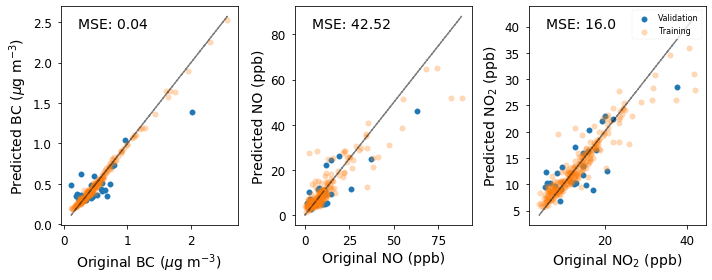

In [120]:
### Plotsnrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    axis.scatter(y, y_hat, label='Validation')
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_train'])
    y = datum['model_data']['y_train']
    axis.scatter(y, y_hat, label='Training', alpha=0.3)
    
    axis.plot(y, y, '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(model["MSE"]["RandomSearch"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
    if i == 2:
        axis.legend(loc='upper right')
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')

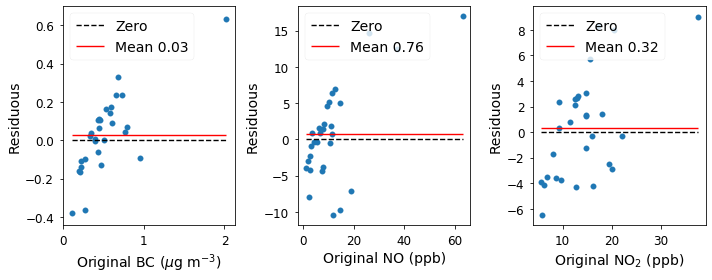

In [788]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    
    axis.scatter(y, y - y_hat)    
    
    axis.hlines(0, y.min(), y.max(), linestyles='--', colors='black', label='Zero')
    
    mean = round((y - y_hat).mean(), 2)
    axis.hlines(mean, y.min(), y.max(), label=f'Mean {mean}', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
#     if  i < 1:
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}_residuous.png')


In [789]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Random Forest': plot_data[i][1]['optimized_random_forest']["MSE"]["RandomSearch"],
        'XGBoost': plot_data[i][1]['optimized_xgboost']["MSE"]["RandomSearch"],
    })
    
pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)

Pollutant,BC,NO,NO$_2$
Random Forest,0.058,49.662,18.593
XGBoost,0.047,39.453,15.998


##### Train with all data with best parameters and get a prediction

In [196]:
results = pd.DataFrame()

for i in range(3):

    model_dict = plot_data[i][1][model_name]
    plot_data[i][1][model_name]['best_estimator'] = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, eval_metric='rmse')\
        .set_params(**model_dict['RandomSearch'].best_params_)\
        .fit(plot_data[i][1]['model_data']['X'], plot_data[i][1]['model_data']['y'])
    a = plot_data[i][1][model_name]['best_estimator']
    results = pd.concat([results ,pd.DataFrame(a.predict(plot_data[i][1]['model_data']['X']), index=plot_data[i][1]['model_data']['X'].index, 
                columns=[plot_data[i][1]['pollutant']])], 1)
    
    results = pd.concat([results,
                         (a.predict(plot_data[i][1]['model_data']['X']) 
                          - plot_data[i][1]['model_data']['y']).to_frame()\
                        .rename(columns={'median': plot_data[i][1]['pollutant'] + '_diff'})], 1)

In [218]:
for i in range(3):

    model_dict = plot_data[i][1][model_name]
    plot_data[i][1][model_name]['best_estimator'] = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, eval_metric='rmse')\
        .set_params(**model_dict['RandomSearch'].best_params_)\
        .fit(plot_data[i][1]['model_data']['X_train'], plot_data[i][1]['model_data']['y_train'])
    a = plot_data[i][1][model_name]['best_estimator']
    print(r2_score(
        plot_data[i][1]['model_data']['y_validation'],
        a.predict(plot_data[i][1]['model_data']['X_validation'])
    ))

0.6710300419106869
0.7178632810792283
0.6023428904459269


In [197]:
results

,BC,BC_diff,NO,NO_diff,NO$_2$,NO$_2$_diff
h3id_9,,,,,,
8928308110bffff,0.782135,-0.016565,15.620544,0.817619,18.195780,-0.065196
89283081143ffff,0.519425,-0.040536,5.131048,-3.247296,13.409148,-2.526140
892830811cfffff,0.386855,0.012913,6.739257,1.346653,12.945893,1.392553
892830810a3ffff,0.490982,0.002415,6.279408,-1.993320,13.661801,-0.103578
89283098387ffff,0.417013,-0.008425,4.719701,-2.000299,8.758101,-1.633160
89283098edbffff,0.322021,0.015653,5.550543,0.979115,10.128897,1.023377
892830812abffff,0.542332,0.015763,10.946610,1.196610,16.236128,0.673127
89283099c03ffff,0.807378,0.036188,27.747440,6.270316,19.182707,0.498312
8928309814bffff,0.463753,-0.016466,6.753743,-1.547140,10.966127,0.317377


In [198]:
results.to_csv(OUTPUT_PATH / 'final_models' / (model_name + '.csv'))

In [165]:
import pickle
pickle.dump(plot_data, open(OUTPUT_PATH / 'final_models' / 'all_models.p', 'wb'))

In [785]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Linear Regression': plot_data[i][1]['optimized_linear_regression']["MSE"]["RandomSearch"],
        'Random Forest': plot_data[i][1]['optimized_random_forest']["MSE"]["RandomSearch"],
        'XGBoost': plot_data[i][1]['optimized_xgboost']["MSE"]["RandomSearch"],
    })
    
a = pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)
a.index.name = 'Model MSE'
a

Pollutant,BC,NO,NO$_2$
Model MSE,,,
Linear Regression,0.089,78.063,25.640
Random Forest,0.058,49.662,18.593
XGBoost,0.047,39.453,15.998


In [ ]:
    datum = plot_data[i][1] 
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])

### Linear Regression

In [193]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

In [194]:
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [197]:
model_name = 'optimized_linear_regression'
for i in range(3):
    
    plot_data[i][1][model_name] = {}
    model_dict = plot_data[i][1][model_name]

    model_dict['estimator'] = LinearRegression()

    model_dict['random_grid'] = {

        }
    
    model_dict['RandomSearch'] = RandomizedSearchCV(estimator=model_dict['estimator'],
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               param_distributions=model_dict['random_grid'], n_iter=300, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_dict['RandomSearch'].fit(plot_data[i][1]['model_data']['X_train'],
                                   plot_data[i][1]['model_data']['y_train'])
    
    model_dict['MSE'] = {}

    print('Standard Estimator ')
    model_dict['MSE']['standard'] = evaluate(model_dict['estimator'].fit(
                         plot_data[i][1]['model_data']['X_train'],
                         plot_data[i][1]['model_data']['y_train']),
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )

    print('Tuned Estimator ')
    model_dict['MSE']['RandomSearch'] = evaluate(model_dict['RandomSearch'].best_estimator_,
             plot_data[i][1]['model_data']['X_validation'],
             plot_data[i][1]['model_data']['y_validation'],
            )
    
    bp = model_dict['RandomSearch'].best_params_
    
    def multiples(x):
        
        if x is None:
            return [None]
        elif x > 1:
            return [float(x), x*2, x*4]
        else:
            return [int(x/2), x, x*2] 

#     model_dict['param_grid'] =  {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

#         # Create a based model
#     model_dict['GridSearchCV'] = GridSearchCV(estimator=model_dict['estimator'],
#                                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
#                                    param_grid=model_dict['param_grid'],  
#                                    cv = 3, verbose=2, n_jobs = -1)
#     # Fit the random search model
#     model_dict['GridSearchCV'].fit(plot_data[i][1]['model_data']['X_train'],
#                                plot_data[i][1]['model_data']['y_train'])
    
#     print('Standard Estimator ')
#     print(model_dict['MSE']['standard'])

#     print('Random Tuned Estimator')
#     print(model_dict['MSE']['RandomSearch'])

#     print('Grid Search Tuned Estimator ')
#     model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
#              plot_data[i][1]['model_data']['X_validation'],
#              plot_data[i][1]['model_data']['y_validation']
#             )
    

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  0.089
Tuned Estimator 
MSE:  0.089
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  78.063
Tuned Estimator 
MSE:  78.063
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  25.64
Tuned Estimator 
MSE:  25.64


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 it

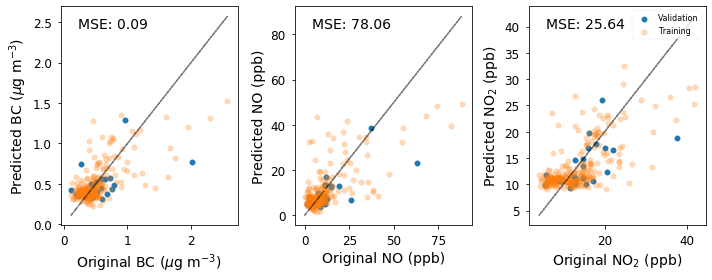

In [198]:
### Plotsnrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    axis.scatter(y, y_hat, label='Validation')
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_train'])
    y = datum['model_data']['y_train']
    axis.scatter(y, y_hat, label='Training', alpha=0.3)
    
    axis.plot(y, y, '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(model["MSE"]["RandomSearch"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
    if i == 2:
        axis.legend(loc='upper right')
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')

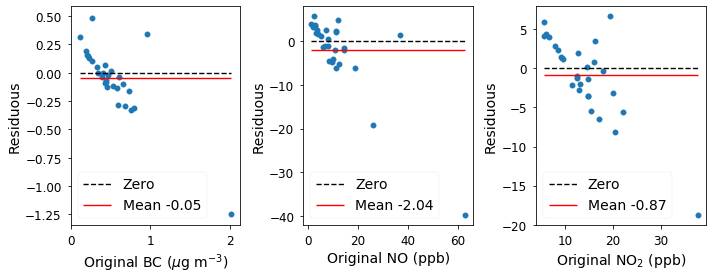

In [202]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(datum['model_data']['X_validation'])
    y = datum['model_data']['y_validation']
    
    axis.scatter(y, y_hat - y)    
    
    axis.hlines(0, y.min(), y.max(), linestyles='--', colors='black', label='Zero')
    
    mean = round((y_hat - y).mean(), 2)
    axis.hlines(mean, y.min(), y.max(), label=f'Mean {mean}', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
#     if  i < 1:
    axis.legend(loc='lower left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}_residuous.png')


In [785]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Linear Regression': plot_data[i][1]['optimized_linear_regression']["MSE"]["RandomSearch"],
        'Random Forest': plot_data[i][1]['optimized_random_forest']["MSE"]["RandomSearch"],
        'XGBoost': plot_data[i][1]['optimized_xgboost']["MSE"]["RandomSearch"],
    })
    
a = pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)
a.index.name = 'Model MSE'
a

Pollutant,BC,NO,NO$_2$
Model MSE,,,
Linear Regression,0.089,78.063,25.640
Random Forest,0.058,49.662,18.593
XGBoost,0.047,39.453,15.998


### Highway Only

In [174]:
to_highway_bool = lambda x: (x['count_highway'] != 0).apply(int).to_frame()

to_highway_bool(plot_data[i][1]['model_data']['X_validation'])

,count_highway
h3id_9,
89283099dc3ffff,0
89283099cb3ffff,0
8928308156bffff,1
892830813cfffff,1
892830813dbffff,1
89283099c93ffff,0
89283098393ffff,0
89283098347ffff,0
892830812b3ffff,0


In [172]:
model_name = 'optimized_linear_regression_highway'

In [100]:

for i in range(3):
    
    plot_data[i][1][model_name] = {}
    model_dict = plot_data[i][1][model_name]

    model_dict['estimator'] = LinearRegression()

    model_dict['random_grid'] = {

        }
    
    model_dict['RandomSearch'] = RandomizedSearchCV(estimator=model_dict['estimator'],
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               param_distributions=model_dict['random_grid'], n_iter=300, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_dict['RandomSearch'].fit(to_highway_bool(plot_data[i][1]['model_data']['X_train']),
                                   plot_data[i][1]['model_data']['y_train'])
    
    model_dict['MSE'] = {}

    print('Standard Estimator ')
    model_dict['MSE']['standard'] = evaluate(model_dict['estimator'].fit(
                         to_highway_bool(plot_data[i][1]['model_data']['X_train']),
                         plot_data[i][1]['model_data']['y_train']),
             to_highway_bool(plot_data[i][1]['model_data']['X_validation']),
             plot_data[i][1]['model_data']['y_validation'],
            )

    print('Tuned Estimator ')
    model_dict['MSE']['RandomSearch'] = evaluate(model_dict['RandomSearch'].best_estimator_,
             to_highway_bool(plot_data[i][1]['model_data']['X_validation']),
             plot_data[i][1]['model_data']['y_validation'],
            )
    
    bp = model_dict['RandomSearch'].best_params_
    
    def multiples(x):
        
        if x is None:
            return [None]
        elif x > 1:
            return [float(x), x*2, x*4]
        else:
            return [int(x/2), x, x*2] 

#     model_dict['param_grid'] =  {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

#         # Create a based model
#     model_dict['GridSearchCV'] = GridSearchCV(estimator=model_dict['estimator'],
#                                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
#                                    param_grid=model_dict['param_grid'],  
#                                    cv = 3, verbose=2, n_jobs = -1)
#     # Fit the random search model
#     model_dict['GridSearchCV'].fit(plot_data[i][1]['model_data']['X_train'],
#                                plot_data[i][1]['model_data']['y_train'])
    
#     print('Standard Estimator ')
#     print(model_dict['MSE']['standard'])

#     print('Random Tuned Estimator')
#     print(model_dict['MSE']['RandomSearch'])

#     print('Grid Search Tuned Estimator ')
#     model_dict['MSE']['GridSearchCV'] = evaluate(model_dict['GridSearchCV'].best_estimator_,
#              plot_data[i][1]['model_data']['X_validation'],
#              plot_data[i][1]['model_data']['y_validation']
#             )
    

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  0.086
Tuned Estimator 
MSE:  0.086
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  95.807
Tuned Estimator 
MSE:  95.807
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Standard Estimator 
MSE:  24.095
Tuned Estimator 
MSE:  24.095


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [169]:
import pickle as p
plot_data = p.load(open(OUTPUT_PATH / 'final_models' / 'all_models.p', 'rb'))

In [170]:
plot_data[0][1].keys()

dict_keys(['pollutant', 'statistic', 'df', 'model_linear_highway_bool', 'model_multilinear_highway', 'model_multilinear', 'model_random_forest', 'model_random_forest_light', 'model_random_forest_less_features', 'model_xgboost_less_features', 'model_data', 'optimized_linear_regression', 'optimized_linear_regression_highway', 'optimized_xgboost'])

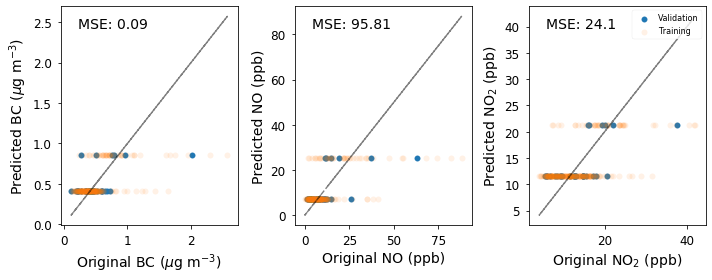

In [175]:
### Plotsnrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(to_highway_bool(datum['model_data']['X_validation']))
    y = datum['model_data']['y_validation']
    axis.scatter(y, y_hat, label='Validation')
    
    y_hat = model['RandomSearch'].best_estimator_.predict(to_highway_bool(datum['model_data']['X_train']))
    
    y = datum['model_data']['y_train']
    axis.scatter(y, y_hat, label='Training', alpha=0.1)
    
    axis.plot(y, y, '--', c='black', alpha=0.5)
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    
    axis.text(0.10, 0.9, f'MSE: {round(model["MSE"]["RandomSearch"], 2)}',
          transform=axis.transAxes, fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
    if i == 2:
        axis.legend(loc='upper right')
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')

['optimized_linear_regression',
 'optimized_linear_regression_highway',
 'optimized_xgboost']

In [188]:

for model_name in [k for k in plot_data[i][1].keys() if 'optimized' in k]:
    print()
    print(model_name)
    for i in range(3):

        model_dict = plot_data[i][1][model_name]
        if model_name == 'optimized_linear_regression_highway':
            r2 = r2_score(
                plot_data[i][1]['model_data']['y_validation'],
                model_dict['RandomSearch'].best_estimator_.predict(to_highway_bool(plot_data[i][1]['model_data']['X_validation']))
            )
            print(r2)
        else:
            r2 = r2_score(
                plot_data[i][1]['model_data']['y_validation'],
                model_dict['RandomSearch'].best_estimator_.predict(
                plot_data[i][1]['model_data']['X_validation'])
            
            print(r2)

SyntaxError: invalid syntax (<ipython-input-188-45111a389e40>, line 20)

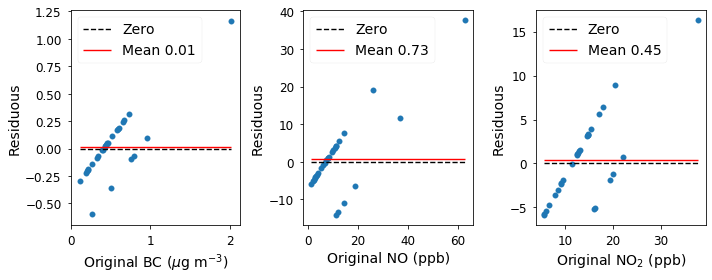

In [110]:
nrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    model = datum[model_name]
    
    y_hat = model['RandomSearch'].best_estimator_.predict(to_highway_bool(datum['model_data']['X_validation']))
    y = datum['model_data']['y_validation']
    
    axis.scatter(y, y - y_hat)    
    
    axis.hlines(0, y.min(), y.max(), linestyles='--', colors='black', label='Zero')
    
    mean = round((y - y_hat).mean(), 2)
    axis.hlines(mean, y.min(), y.max(), label=f'Mean {mean}', colors='red')
    
    axis.set_xlabel('Original {} ({})'.format(datum['pollutant'], 
                                     concentration_labels[datum['pollutant']]), 
                    fontsize=fontsize)
    axis.set_ylabel('Residuous', 
                    fontsize=fontsize)
#     if  i < 1:
    axis.legend(loc='upper left', fontsize=fontsize)
    
    axis.tick_params(axis='both', labelsize=12)
    
plot_box(plot_data[0][1], ax[0], 0)
plot_box(plot_data[1][1], ax[1], 1)
plot_box(plot_data[2][1], ax[2], 2)

fig.tight_layout()
fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}_residuous.png')


In [334]:
results = []

for i in range(3):
    
    results.append({
        'Pollutant': plot_data[i][1]['pollutant'],
        'Highway Linear Regression': plot_data[i][1]['optimized_linear_regression_highway']["MSE"]["RandomSearch"],
        'Linear Regression': mse_3[i],
        'Random Forest': mse[i],
        'XGBoost': mse_2[i],
    })
    
a = pd.DataFrame(results).set_index('Pollutant').T.sort_values(by='NO', ascending=False)
a.index.name = 'Model MSE'
a

Pollutant,BC,NO,NO$_2$
Model MSE,,,
Highway Linear Regression,0.086,95.807,24.095
Linear Regression,0.089,78.063,25.640
Random Forest,0.058,49.662,18.593
XGBoost,0.047,39.453,15.998


In [337]:
print(a.to_latex())

\begin{tabular}{lrrr}
\toprule
Pollutant &     BC &      NO &  NO\$\_2\$ \\
Model MSE                 &        &         &         \\
\midrule
Highway Linear Regression &  0.086 &  95.807 &  24.095 \\
Linear Regression         &  0.089 &  78.063 &  25.640 \\
Random Forest             &  0.058 &  49.662 &  18.593 \\
XGBoost                   &  0.047 &  39.453 &  15.998 \\
\bottomrule
\end{tabular}



In [116]:
mse_2 = [0.047, 39.453, 15.998]
mse_3 = [0.089, 78.063, 25.640]

## New Feature Importance

In [48]:
import rfpimp
import xgboost as xgb
from copy import deepcopy

In [66]:
waze_features = pd.read_csv(RAW_PATH / 'waze_features_05_23.csv', index_col='h3id_9')
waze_features = waze_features.drop('h3id_9.1', axis=1)

In [67]:
waze_features.head(1)

,max_counta,avg_congested_prop,max_length,max_avg_speed,min_avg_speed,avg_speed,max_median_level,min_median_level,median_level,bool_highway,bool_primary,bool_ramps,bool_secondary,count_highway,count_streets,count_primary,count_secondary,count_primary_street,count_primary_ramps,usual_road_type
h3id_9,,,,,,,,,,,,,,,,,,,,
8928308110bffff,2,433.31058,994,7.744444,0.427778,2.88303,4,2,4,0,1,1,0,0,0,110,0,11,189,4


In [68]:
plot_data_ = deepcopy(plot_data)

### Exclude Correlated Values

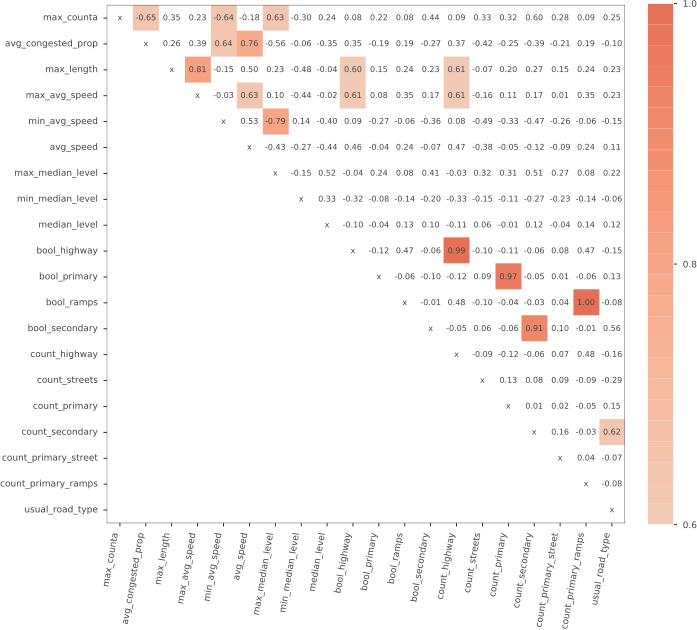

In [69]:
viz = rfpimp.plot_corr_heatmap(waze_features, figsize=(10, 10))
viz

In [70]:
dep = rfpimp.feature_dependence_matrix(waze_features)

In [71]:
dep.sort_values(by='Dependence', ascending=False)['Dependence']

bool_highway             0.996297
bool_ramps                0.99568
bool_secondary           0.993753
bool_primary             0.984858
avg_congested_prop       0.863166
avg_speed                0.838371
max_length               0.832502
max_avg_speed            0.829563
max_median_level         0.825999
max_counta               0.778947
usual_road_type           0.70517
min_avg_speed            0.679154
median_level             0.648893
count_secondary          0.617311
count_primary            0.486377
min_median_level         0.419204
count_streets            0.105751
count_highway           0.0725372
count_primary_street   -0.0666662
count_primary_ramps    -0.0728842
Name: Dependence, dtype: object

In [78]:
dep.sort_values(by='Dependence', ascending=False).loc['max_avg_speed']

Dependence                0.829563
max_counta                       0
avg_congested_prop      0.00389126
max_length                0.513264
max_avg_speed                    1
min_avg_speed           0.00176829
avg_speed                0.0477248
max_median_level                 0
min_median_level         0.0818475
median_level            0.00170198
bool_highway                     0
bool_primary                     0
bool_ramps                       0
bool_secondary                   0
count_highway             0.178241
count_streets                    0
count_primary           0.00112515
count_secondary                  0
count_primary_street    0.00267144
count_primary_ramps     0.00805578
usual_road_type          0.0014904
Name: max_avg_speed, dtype: object

#### Excluding >0.9 dependency

In [74]:
waze_features.columns

Index(['max_counta', 'avg_congested_prop', 'max_length', 'max_avg_speed',
       'min_avg_speed', 'avg_speed', 'max_median_level', 'min_median_level',
       'median_level', 'bool_highway', 'bool_primary', 'bool_ramps',
       'bool_secondary', 'count_highway', 'count_streets', 'count_primary',
       'count_secondary', 'count_primary_street', 'count_primary_ramps',
       'usual_road_type'],
      dtype='object')

In [79]:
exclude_features = ['bool_highway', 'bool_primary', 'bool_ramps', 'bool_secondary']

In [80]:
waze_features_ = waze_features.drop(exclude_features, axis=1)

#### Run dependency again

In [83]:
dep = rfpimp.feature_dependence_matrix(waze_features_)

In [84]:
dep.sort_values(by='Dependence', ascending=False)['Dependence']

avg_congested_prop       0.857891
avg_speed                0.841701
max_avg_speed            0.817614
max_median_level         0.813325
max_length               0.802859
max_counta               0.789078
usual_road_type          0.715932
min_avg_speed            0.666776
median_level             0.656521
count_secondary          0.632478
min_median_level         0.453937
count_primary            0.344374
count_streets            0.281754
count_highway            0.044015
count_primary_street   -0.0233961
count_primary_ramps     -0.356508
Name: Dependence, dtype: object

#### Prepare datasets

In [99]:
import sklearn.metrics as m

In [100]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

for i in range(3):
    df = waze_features_.merge(plot_data[i][1]['df'].reset_index()[['h3id_9', 'median']], 
                                           on='h3id_9')\
        .set_index('h3id_9')
    
    # Spliting
    df_train, df_validation = train_test_split(df, train_size=0.9)

    plot_data_[i][1]['model_data'] = {}
    plot_data_[i][1]['model_data']['X'] = df.drop('median', axis=1)
    plot_data_[i][1]['model_data']['y'] = df['median']
    plot_data_[i][1]['model_data']['X_train'] = df_train.drop('median', axis=1)
    plot_data_[i][1]['model_data']['X_validation'] = df_validation.drop('median', axis=1)
    plot_data_[i][1]['model_data']['y_train'] = df_train['median']
    plot_data_[i][1]['model_data']['y_validation'] = df_validation['median']

In [97]:
plot_data_[i][1]['model_data']['X'].columns

Index(['max_counta', 'avg_congested_prop', 'max_length', 'max_avg_speed',
       'min_avg_speed', 'avg_speed', 'max_median_level', 'min_median_level',
       'median_level', 'count_highway', 'count_streets', 'count_primary',
       'count_secondary', 'count_primary_street', 'count_primary_ramps',
       'usual_road_type'],
      dtype='object')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [159]:
def calculate_xgb_importance(plot_data_, i):
    
    imps = []
    
    for j in range(50):
        
        rf = b[i][1]['optimized_xgboost']['estimator']
        
#         rf.fit(plot_data_[i][1]['model_data']['X_train'],
#                plot_data_[i][1]['model_data']['y_train'])

        imp = rfpimp.importances(rf, 
                          plot_data_[i][1]['model_data']['X_validation'], 
                          plot_data_[i][1]['model_data']['y_validation']) # permutation

        imps.append(imp)

    return pd.concat(imps, axis=1).T.describe().T[['mean']].rename(columns={'mean':'Importance'})


In [ ]:
def calculate_xgb_importance(plot_data_, i):
    
        
    rf = xgb.XGBRegressor()

    rf.fit(plot_data_[i][1]['model_data']['X_train'],
           plot_data_[i][1]['model_data']['y_train'])

    imp = rfpimp.importances(rf, 
                      plot_data_[i][1]['model_data']['X_validation'], 
                      plot_data_[i][1]['model_data']['y_validation']) # permutation



    return impn


In [139]:
import pickle as p
b = p.load(open(OUTPUT_PATH / 'final_models' / 'all_models.p', 'rb'))

In [137]:
a = calculate_xgb_importance(plot_data_, 1)

In [138]:
a.T.describe().T[['mean', 'std']]

,mean,std
avg_congested_prop,-0.016480,0.068433
avg_speed,0.006658,0.070503
count_highway,0.034172,0.088066
count_primary,0.053196,0.068888
count_primary_ramps,0.346466,0.132544
count_primary_street,0.012283,0.028951
count_secondary,-0.005958,0.049268
count_streets,-0.019782,0.023802
max_avg_speed,0.077369,0.077746
max_counta,0.006233,0.018309


ValueError: feature_names mismatch: ['avg_congested_prop', 'max_length', 'avg_speed', 'min_median_level', 'bool_highway', 'bool_ramps', 'count_highway', 'count_streets', 'count_primary', 'count_secondary', 'count_primary_street', 'count_primary_ramps'] ['max_counta', 'avg_congested_prop', 'max_length', 'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level', 'min_median_level', 'median_level', 'count_highway', 'count_streets', 'count_primary', 'count_secondary', 'count_primary_street', 'count_primary_ramps', 'usual_road_type']
expected bool_ramps, bool_highway in input data
training data did not have the following fields: usual_road_type, min_avg_speed, max_avg_speed, max_counta, max_median_level, median_level

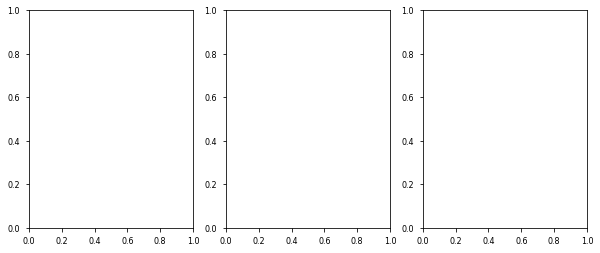

In [160]:
### Plotsnrows = 1
ncols = 3
fontsize = 14

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=(10, 4))
def plot_box(datum, axis, i):
    
    imp = calculate_xgb_importance(datum, i).sort_values(by='Importance', ascending=True)
    
    axis.barh(imp.index, imp['Importance'])
    

    axis.set_xlabel('Importance')

#     axis.set_ylabel('Predicted {} ({})'.format(datum['pollutant'], 
#                                      concentration_labels[datum['pollutant']]), 
#                     fontsize=fontsize)
    
    axis.text(0.7, 0.1, datum[i][1]['pollutant'],
          transform=axis.transAxes, fontsize=fontsize)
    
#     axis.tick_params(axis='both', labelsize=12)
    
#     if i == 2:
#         axis.legend(loc='upper right')
    
plot_box(plot_data_, ax[0], 0)
plot_box(plot_data_, ax[1], 1)
plot_box(plot_data_, ax[2], 2)

fig.tight_layout()
# fig.savefig(IMGS_PATH / 'waze_models' / f'{model_name}.png')